In [ ]:
# %%
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM

In [ ]:
model = AutoModelForMaskedLM.from_pretrained(
    "ibm-research/MoLFormer-XL-both-10pct", trust_remote_code=True, dtype="auto"
)
tokenizer = AutoTokenizer.from_pretrained(
    "ibm/MoLFormer-XL-both-10pct", trust_remote_code=True
)

In [ ]:
compounds = pd.read_csv(
    "./MoABox_compounds_metadata.txt",
    sep="\t",
).dropna(subset="smiles")
compounds

,cmpd_sample_id,inchi_key,smiles,cas_number,moa
503,EF-73-IP33,AAAQFGUYHFJNHI-SFHVURJKSA-N,CCNC(=O)C[C@@H]1N=C(c2ccc(Cl)cc2)c2cc(OC)ccc2-...,1260907-17-2,BRD2/3/4/T BET familiy inhibitor
504,DE-81-OY65,AAKJLRGGTJKAMG-UHFFFAOYSA-N,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1,1429636-49-6,Inhibitors of Signal Transduction Pathways;EGF...
505,IC-57-ZA36,AAOYLOCWJSLLJU-UHFFFAOYSA-N,O=C(C(=O)c1cc(Br)ccc1O)c1cc(Br)ccc1O,523-88-6,Carboxylesterase Inhibitors
506,RA-81-JZ66,AASYYGYJPZBFKC-UHFFFAOYSA-N,O=C(O)Cc1c(C(=O)O)n(Cc2cccc3ccccc23)c2ccc(F)cc12,942191-15-3,Known Chymase inhibitor
507,BD-60-ZK54,AATHJLXYARFGKZ-UHFFFAOYSA-N,O=C(c1ccc(-c2cc[n+]([O-])cc2)cc1)N1CCN(S(=O)(=...,216957-20-9,Inhibitors of Blood Coagulation Pathways;Coagu...
...,...,...,...,...,...
4340,AD-89-ID99,ZZUFCTLCJUWOSV-UHFFFAOYSA-N,NS(=O)(=O)c1cc(C(=O)O)c(NCc2ccco2)cc1Cl,106391-48-4,Antidiuretic
4341,AC-51-WE57,ZZVUWRFHKOJYTH-UHFFFAOYSA-N,CN(C)CCOC(c1ccccc1)c1ccccc1,110491-04-8,Histamine H1 Receptor Antagonists
4342,JF-12-EH36,ZZXIRFDFHJBYCS-UHFFFAOYSA-N,CC1(C)CCn2cncc2C1c1ccc(C#N)cc1,NaN,Cytochrome P450 11B2 (Aldosterone Synthase) In...
4343,SB-29-AN01,ZZYMTFSRMGVTHN-MLGOLLRUSA-N,C[C@@H]1CN(C(=O)[C@@](C)(O)C(F)(F)F)CCN1C(=O)O...,NaN,Pyruvate Dehydrogenase Kinase (PDHK;PDK) Inhib...


In [ ]:
# %%
# Filter out invalid SMILES (NaN, None, empty strings)
smiles = compounds["smiles"].dropna().astype(str).tolist()
smiles = [s for s in smiles if s and s.strip() and s != "nan"]
print(f"Number of valid SMILES: {len(smiles)}")
smiles[:5]  # Show first 5

# %%
# Process in batches to avoid memory issues
batch_size = 64
all_embeddings = []

for i in range(0, len(smiles), batch_size):
    batch = smiles[i : i + batch_size]
    print(
        f"Processing batch {i // batch_size + 1}/{(len(smiles) - 1) // batch_size + 1} ({len(batch)} compounds)"
    )

    # Tokenize and get embeddings
    inputs = tokenizer(
        batch, padding=True, return_tensors="pt", truncation=True, max_length=512
    )

    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)

    # Extract embeddings from the last hidden state (mean pooling)
    # Shape: (batch_size, sequence_length, hidden_size)
    hidden_states = outputs.hidden_states[-1]

    # Mean pooling over sequence length
    # Shape: (batch_size, hidden_size)
    embeddings = hidden_states.mean(dim=1)

    all_embeddings.append(embeddings)

# Concatenate all batch embeddings
all_embeddings = torch.cat(all_embeddings, dim=0)
print(f"\nFinal embeddings shape: {all_embeddings.shape}")
all_embeddings

Number of valid SMILES: 3837
Processing batch 1/60 (64 compounds)
Processing batch 2/60 (64 compounds)
Processing batch 3/60 (64 compounds)
Processing batch 4/60 (64 compounds)
Processing batch 5/60 (64 compounds)
Processing batch 6/60 (64 compounds)
Processing batch 7/60 (64 compounds)
Processing batch 8/60 (64 compounds)
Processing batch 9/60 (64 compounds)
Processing batch 10/60 (64 compounds)
Processing batch 11/60 (64 compounds)
Processing batch 12/60 (64 compounds)
Processing batch 13/60 (64 compounds)
Processing batch 14/60 (64 compounds)
Processing batch 15/60 (64 compounds)
Processing batch 16/60 (64 compounds)
Processing batch 17/60 (64 compounds)
Processing batch 18/60 (64 compounds)
Processing batch 19/60 (64 compounds)
Processing batch 20/60 (64 compounds)
Processing batch 21/60 (64 compounds)
Processing batch 22/60 (64 compounds)
Processing batch 23/60 (64 compounds)
Processing batch 24/60 (64 compounds)
Processing batch 25/60 (64 compounds)
Processing batch 26/60 (64 com

tensor([[-0.1830,  0.4729, -0.5937,  ..., -0.2692,  0.1804,  0.7420],
        [-0.1106, -0.3270, -0.1049,  ..., -0.3578, -0.9845,  0.3801],
        [ 0.0998, -0.6284, -0.4284,  ..., -0.6495, -0.2155,  1.3673],
        ...,
        [-0.1840, -0.0446, -0.5838,  ..., -0.4333,  0.2146, -0.0206],
        [-0.6655,  0.6483, -0.7123,  ...,  0.5570, -0.8765,  0.6744],
        [ 0.8706, -0.7090,  0.5766,  ..., -0.1066,  0.0948,  0.7603]])

In [ ]:
all_embeddings_numpy = all_embeddings.detach().numpy()
all_embeddings_numpy

array([[-0.18298502,  0.4729225 , -0.59367764, ..., -0.2691781 ,
         0.18040463,  0.74200374],
       [-0.11063173, -0.32704747, -0.10491193, ..., -0.3577929 ,
        -0.98445195,  0.3801234 ],
       [ 0.09981771, -0.6284255 , -0.42841464, ..., -0.64951044,
        -0.21548285,  1.3673289 ],
       ...,
       [-0.18401682, -0.04456035, -0.5837763 , ..., -0.4332512 ,
         0.21457976, -0.02064092],
       [-0.6654667 ,  0.64825535, -0.71229273, ...,  0.5570074 ,
        -0.8764728 ,  0.6743665 ],
       [ 0.87055594, -0.70903915,  0.57656467, ..., -0.10664605,
         0.09478699,  0.7602808 ]], shape=(3837, 768), dtype=float32)

In [ ]:
df = pd.DataFrame(all_embeddings_numpy, index=smiles)
df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
CCNC(=O)C[C@@H]1N=C(c2ccc(Cl)cc2)c2cc(OC)ccc2-n2c(C)nnc21,-0.182985,0.472923,-0.593678,0.865107,-1.029428,-0.932324,-0.232771,0.693612,0.108017,0.564329,...,-0.595828,-0.380680,-0.768098,0.551401,0.840306,0.670570,-1.075073,-0.269178,0.180405,0.742004
C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1,-0.110632,-0.327047,-0.104912,0.187973,-1.272995,-1.171253,0.455273,0.534166,-0.395821,0.767935,...,0.709788,0.012661,-0.012221,-0.164215,-0.278843,0.046955,-2.478580,-0.357793,-0.984452,0.380123
O=C(C(=O)c1cc(Br)ccc1O)c1cc(Br)ccc1O,0.099818,-0.628425,-0.428415,1.279389,-1.045884,-1.040532,-0.910325,0.746696,0.233632,0.708870,...,-0.226639,-0.137162,-0.126234,0.464495,-0.246690,0.202188,-1.960772,-0.649510,-0.215483,1.367329
O=C(O)Cc1c(C(=O)O)n(Cc2cccc3ccccc23)c2ccc(F)cc12,-0.804037,0.610580,-0.068153,0.592107,-0.521015,-1.442616,-0.206297,1.102629,0.189211,-0.447201,...,0.921270,-0.847681,-0.221307,0.014421,0.204752,0.195068,-2.007383,-0.269652,0.002382,0.643331
O=C(c1ccc(-c2cc[n+]([O-])cc2)cc1)N1CCN(S(=O)(=O)c2ccc3cc(Cl)ccc3c2)CC1,0.412289,0.575043,0.318309,0.368367,-0.476263,-0.567235,0.348560,0.171393,0.805039,0.151185,...,0.246887,0.086307,-0.007626,0.210879,0.243042,0.205759,-1.914346,-0.309737,-0.603711,0.440789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NS(=O)(=O)c1cc(C(=O)O)c(NCc2ccco2)cc1Cl,-0.580093,-0.214176,-0.499617,-0.181651,-0.409799,-0.806508,-0.402137,-0.131349,0.532617,0.167724,...,0.180728,-0.557186,0.265666,-0.195928,0.150760,0.303779,-1.533506,0.109172,-0.601732,-0.006838
CN(C)CCOC(c1ccccc1)c1ccccc1,-0.173441,-0.019101,-0.393530,0.326170,-1.472539,-0.741139,0.340527,1.869310,0.551133,-0.954891,...,1.055760,0.845617,-1.047638,0.210888,-0.179256,0.427719,-1.192930,0.144402,-1.023497,0.350286
CC1(C)CCn2cncc2C1c1ccc(C#N)cc1,-0.184017,-0.044560,-0.583776,0.098545,-1.053553,-0.792608,-0.393189,1.315863,0.511898,-0.026497,...,0.778029,-0.426205,-0.315594,0.496351,-1.242979,0.574123,-2.178664,-0.433251,0.214580,-0.020641
C[C@@H]1CN(C(=O)[C@@](C)(O)C(F)(F)F)CCN1C(=O)OCc1ccccc1,-0.665467,0.648255,-0.712293,0.260102,0.348925,-0.959861,-1.299593,0.152314,0.896235,0.075309,...,0.583820,0.101313,0.404807,-0.388649,0.438144,1.218511,-1.642194,0.557007,-0.876473,0.674366


In [ ]:
res = df.merge(compounds, left_index=True, right_on="smiles").set_index(
    compounds.columns.tolist()
)
res.to_csv("./drug4k_smiles-embeddings.tsv", sep="\t")
res

,,,,,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
cmpd_sample_id,inchi_key,smiles,cas_number,moa,,,,,,,,,,,,,,,,,,,,,
EF-73-IP33,AAAQFGUYHFJNHI-SFHVURJKSA-N,CCNC(=O)C[C@@H]1N=C(c2ccc(Cl)cc2)c2cc(OC)ccc2-n2c(C)nnc21,1260907-17-2,BRD2/3/4/T BET familiy inhibitor,-0.182985,0.472923,-0.593678,0.865107,-1.029428,-0.932324,-0.232771,0.693612,0.108017,0.564329,...,-0.595828,-0.380680,-0.768098,0.551401,0.840306,0.670570,-1.075073,-0.269178,0.180405,0.742004
DE-81-OY65,AAKJLRGGTJKAMG-UHFFFAOYSA-N,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1,1429636-49-6,Inhibitors of Signal Transduction Pathways;EGFR (HER1 or erbB1) Inhibitors,-0.110632,-0.327047,-0.104912,0.187973,-1.272995,-1.171253,0.455273,0.534166,-0.395821,0.767935,...,0.709788,0.012661,-0.012221,-0.164215,-0.278843,0.046955,-2.478580,-0.357793,-0.984452,0.380123
IC-57-ZA36,AAOYLOCWJSLLJU-UHFFFAOYSA-N,O=C(C(=O)c1cc(Br)ccc1O)c1cc(Br)ccc1O,523-88-6,Carboxylesterase Inhibitors,0.099818,-0.628425,-0.428415,1.279389,-1.045884,-1.040532,-0.910325,0.746696,0.233632,0.708870,...,-0.226639,-0.137162,-0.126234,0.464495,-0.246690,0.202188,-1.960772,-0.649510,-0.215483,1.367329
RA-81-JZ66,AASYYGYJPZBFKC-UHFFFAOYSA-N,O=C(O)Cc1c(C(=O)O)n(Cc2cccc3ccccc23)c2ccc(F)cc12,942191-15-3,Known Chymase inhibitor,-0.804037,0.610580,-0.068153,0.592107,-0.521015,-1.442616,-0.206297,1.102629,0.189211,-0.447201,...,0.921270,-0.847681,-0.221307,0.014421,0.204752,0.195068,-2.007383,-0.269652,0.002382,0.643331
BD-60-ZK54,AATHJLXYARFGKZ-UHFFFAOYSA-N,O=C(c1ccc(-c2cc[n+]([O-])cc2)cc1)N1CCN(S(=O)(=O)c2ccc3cc(Cl)ccc3c2)CC1,216957-20-9,Inhibitors of Blood Coagulation Pathways;Coagulation Factor Xa Inhibitors,0.412289,0.575043,0.318309,0.368367,-0.476263,-0.567235,0.348560,0.171393,0.805039,0.151185,...,0.246887,0.086307,-0.007626,0.210879,0.243042,0.205759,-1.914346,-0.309737,-0.603711,0.440789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AD-89-ID99,ZZUFCTLCJUWOSV-UHFFFAOYSA-N,NS(=O)(=O)c1cc(C(=O)O)c(NCc2ccco2)cc1Cl,106391-48-4,Antidiuretic,-0.580093,-0.214176,-0.499617,-0.181651,-0.409799,-0.806508,-0.402137,-0.131349,0.532617,0.167724,...,0.180728,-0.557186,0.265666,-0.195928,0.150760,0.303779,-1.533506,0.109172,-0.601732,-0.006838
AC-51-WE57,ZZVUWRFHKOJYTH-UHFFFAOYSA-N,CN(C)CCOC(c1ccccc1)c1ccccc1,110491-04-8,Histamine H1 Receptor Antagonists,-0.173441,-0.019101,-0.393530,0.326170,-1.472539,-0.741139,0.340527,1.869310,0.551133,-0.954891,...,1.055760,0.845617,-1.047638,0.210888,-0.179256,0.427719,-1.192930,0.144402,-1.023497,0.350286
JF-12-EH36,ZZXIRFDFHJBYCS-UHFFFAOYSA-N,CC1(C)CCn2cncc2C1c1ccc(C#N)cc1,NaN,Cytochrome P450 11B2 (Aldosterone Synthase) Inhibitors;Cytochrome P450 CYP11B1 (Steroid 11-beta Hydroxylase) Inhibitors,-0.184017,-0.044560,-0.583776,0.098545,-1.053553,-0.792608,-0.393189,1.315863,0.511898,-0.026497,...,0.778029,-0.426205,-0.315594,0.496351,-1.242979,0.574123,-2.178664,-0.433251,0.214580,-0.020641


2384

In [ ]:
import anndata as ad

In [ ]:
import scanpy as sc

In [ ]:
adata = ad.AnnData(res.values, obs=res.index.to_frame(index=False))
adata

/Users/lucas-diedrich/mamba/envs/hackathon/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


AnnData object with n_obs × n_vars = 3839 × 768
    obs: 'cmpd_sample_id', 'inchi_key', 'smiles', 'cas_number', 'moa'

In [ ]:
counts = adata.obs["moa"].value_counts()
color_moa = counts[counts > 5].index
color_moa

CategoricalIndex(['Histone Deacetylase (HDAC) Inhibitors',
                  'Carbonic anhydrase inhibitor', 'CDK Inhibitors',
                  '5-HT3 receptor agonist', 'alpha-Adrenoceptor Antagonists',
                  'Dipeptidyl Peptidase IV (CD26;DPP-IV;DP-IV) Inhibitors',
                  'Carboxylesterase Inhibitors',
                  'alpha1-Adrenoceptor Antagonists',
                  'Calcium-Sensing Receptor (CaSR) Antagonists;Parathyroid Hormone Secretion Stimulants',
                  'mgluR5 Antagonists', 'Phosphodiesterase IV Inhibitors',
                  'Protein Kinase C (PKC) Inhibitors', 'SCD inhibitor',
                  'Renin Inhibitors',
                  'Pyruvate Dehydrogenase Kinase (PDHK;PDK) Inhibitors',
                  'splicing modulator', 'VEGFR-2 (FLK-1/KDR) Inhibitors',
                  'Peptide Deformylase (PDF) Inhibitors', 'CDK4 Inhibitors',
                  'Cathepsin S Inhibitors'],
                 categories=['1 Epidermal  transglutamina

In [ ]:
import numpy as np

In [ ]:
adata.obs["moa_streamlined"] = adata.obs["moa"].apply(
    lambda moa: moa if moa in color_moa else np.nan
)
adata.obs["moa_streamlined"]

0                               NaN
1                               NaN
2       Carboxylesterase Inhibitors
3                               NaN
4                               NaN
                   ...             
3834                            NaN
3835                            NaN
3836                            NaN
3837                            NaN
3838                            NaN
Name: moa_streamlined, Length: 3839, dtype: object

In [ ]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Text(0.0, 1.0, 'Mechanism of action')

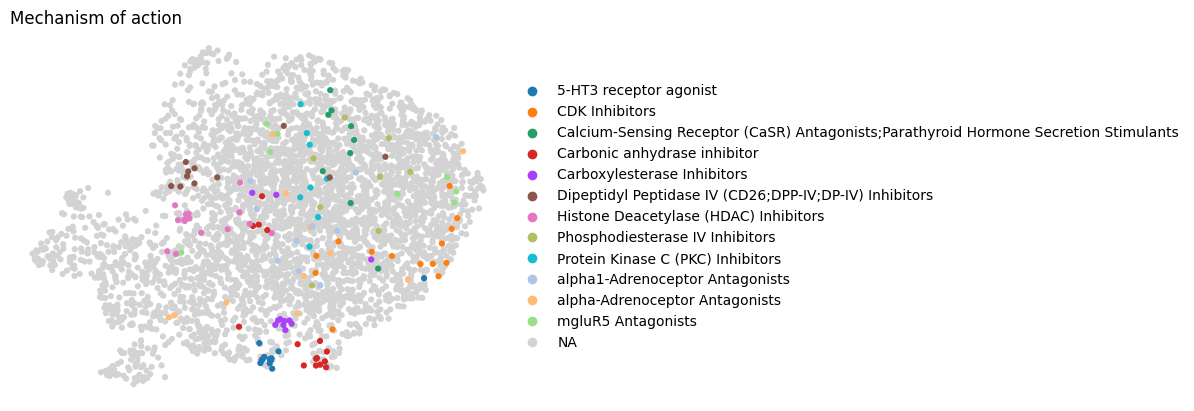

In [ ]:
ax = sc.pl.umap(adata, color="moa_streamlined", size=80, show=False, title="")
ax.set_axis_off()
ax.set_title("Mechanism of action", loc="left")